In [1]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt

In [2]:
nside = 512
mission_time_is_sec = 24 * 3600
instrument = "MFT"
channel = "M1-140"
sampling = 1  # this replaces channelinfo.sampling_rate_hz

In [3]:
imo = lbs.Imo()
sim = lbs.Simulation(
    base_path="./tutorial",
    start_time=0,
    duration_s=mission_time_is_sec,
)

In [4]:
mft_file = sim.imo.query("/releases/v1.0/satellite/" + instrument + "/instrument_info")
sim.generate_spin2ecl_quaternions(
    imo_url="/releases/v1.0/satellite/scanning_parameters/"
)
instrumentinfo = lbs.InstrumentInfo(
    name=instrument,
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
)
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/" + instrument + "/" + channel + "/channel_info",
    imo=imo,
)
hwp_radpsec = mft_file.metadata["hwp_rpm"] * 2.0 * np.pi / 60.0

In [5]:
dets = []
detquats = []
# for detname in channelinfo.detector_names[0:20]:
for detname in channelinfo.detector_names:
    det = lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"
        + instrument
        + "/"
        + channel
        + "/"
        + detname
        + "/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

## Fill tod and then build map

In [6]:
(obs,) = sim.create_observations(detectors=dets)

pointings = lbs.get_pointings(
    obs,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    detector_quats=detquats,
    bore2spin_quat=instrumentinfo.bore2spin_quat,
)

In [7]:
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=False,
    gaussian_smooth=True,
    bandpass_int=False,
    nside=nside,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=channelinfo,
)
maps = mbs.run_all()[0][channel]

[2021-10-12 23:21:30,616 INFO MPI#0000] generating and saving cmb simulations


***************** D
***************** D
***************** D


/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211012.fits
  warnings.warn(f"Access data from {full_path}")


In [8]:
hwp_sys = lbs.HwpSys(sim)
hwp_sys.set_parameters(
    maps=maps,
    integrate_in_band=False,
    correct_in_solver=False,
    built_map_on_the_fly=False,
    nside=nside,
)

In [9]:
hwp_sys.fill_tod(obs, pointings, hwp_radpsec)
obs.tod *= 2.0  #

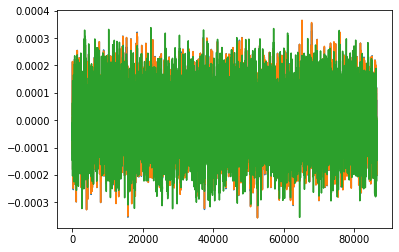

In [10]:
plt.plot(obs.tod[0])
plt.plot(obs.tod[1])
plt.plot(obs.tod[2])

In [11]:
m = lbs.make_bin_map([obs], nside).T

/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/Users/luca/opt/anaconda3/envs/litebird_sim_hwp/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationW

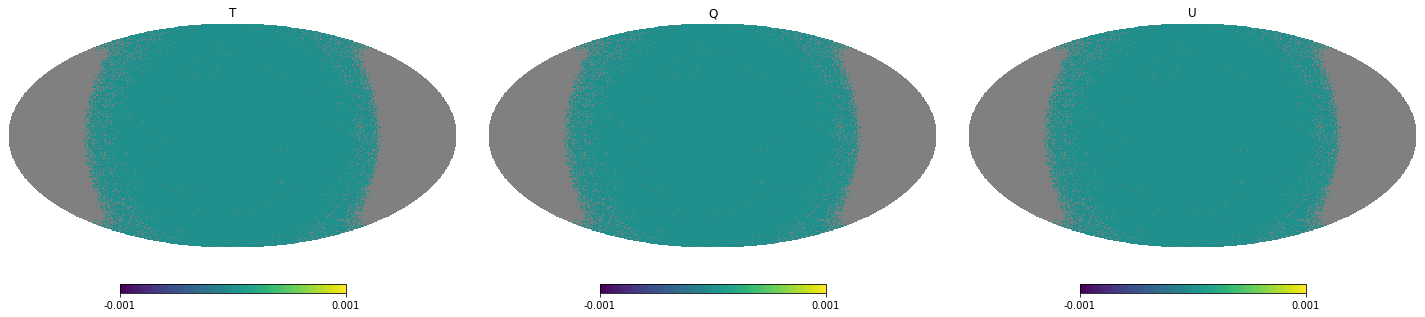

In [12]:
fig = plt.figure(figsize=(20, 10))
hp.mollview(m[0] - maps[0], sub=131, title="T", min=-1e-3, max=1e-3)
hp.mollview(m[1] - maps[1], sub=132, title="Q", min=-1e-3, max=1e-3)
hp.mollview(m[2] - maps[2], sub=133, title="U", min=-1e-3, max=1e-3)

## Built map on the fly

In [13]:
# obs.tod not allocated
obs = lbs.Observation(
    [asdict(d) for d in dets],
    int(sim.duration_s * sampling),
    sim.start_time,
    sampling,
    allocate_tod=False,
)
pointings = lbs.get_pointings(
    obs,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    detector_quats=detquats,
    bore2spin_quat=instrumentinfo.bore2spin_quat,
)

In [14]:
hwp_sys = lbs.HwpSys(sim)
# Here the obs.tod is not filled
hwp_sys.set_parameters(
    maps=maps,
    integrate_in_band=False,
    correct_in_solver=False,
    built_map_on_the_fly=True,
    nside=nside,
)

In [15]:
hwp_sys.fill_tod(obs, pointings, hwp_radpsec)

In [16]:
m = hwp_sys.make_map([obs])

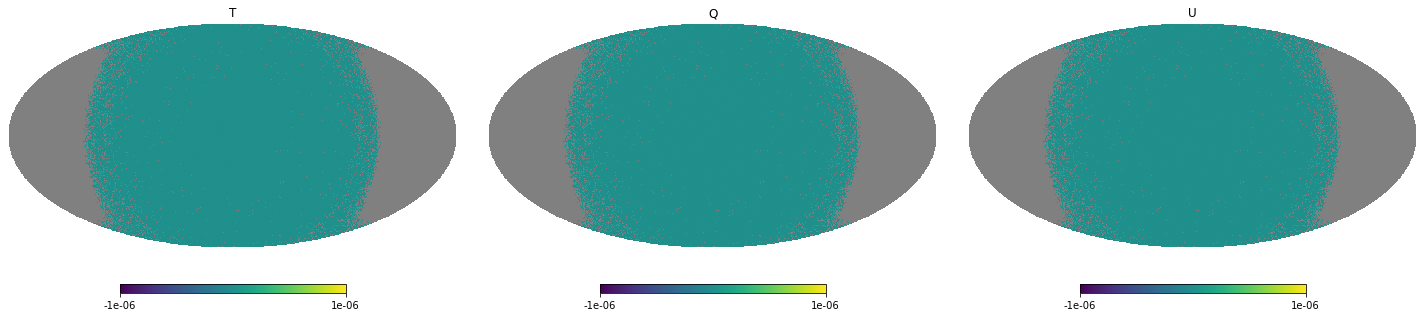

In [18]:
fig = plt.figure(figsize=(20, 10))
hp.mollview(m[0] - maps[0], sub=131, title="T", min=-1e-6, max=1e-6)
hp.mollview(m[1] - maps[1], sub=132, title="Q", min=-1e-6, max=1e-6)
hp.mollview(m[2] - maps[2], sub=133, title="U", min=-1e-6, max=1e-6)